In [ ]:
import os,shutil

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


source: https://github.com/vishal1905/ESRGAN-Enhanced-Super-Resolution/blob/master/ESRGAN.ipynb

In [ ]:
import os
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
from torchsummary import summary
import torch.optim as optim
from torchvision import models, datasets
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook,tqdm
import cv2
import torchvision.utils as vutils

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def downloadSampling(img):
    image = np.array(img)
    image_blur = cv2.resize(image,(64,64),cv2.INTER_CUBIC)
    new_image = Image.fromarray(image_blur)
    return new_image

In [ ]:
HR_transform = transforms.Compose([
                                 transforms.Resize((256,256)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

In [ ]:
LR_transform = transforms.Compose([
                                   transforms.Resize((256,256)),
                                   transforms.Lambda(downloadSampling),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

In [ ]:
#HR_train_dataset = datasets.CelebA(root = "celebA",transform = HR_transform, download = False)
HR_train_dataset = datasets.ImageFolder(root = "/content/drive/MyDrive/datasets/DIV2K/ESRGAN/train/HR",transform = HR_transform)
HR_train_dataloader = DataLoader(HR_train_dataset, batch_size = 4, num_workers = 4 )

In [ ]:
#LR_train_dataset = datasets.CelebA(root = "celebA",transform = LR_transform, download = True)
LR_train_dataset = datasets.ImageFolder(root = "/content/drive/MyDrive/datasets/DIV2K/ESRGAN/train/HR",transform = LR_transform)
LR_train_dataloader = DataLoader(LR_train_dataset, batch_size = 4, num_workers = 4)

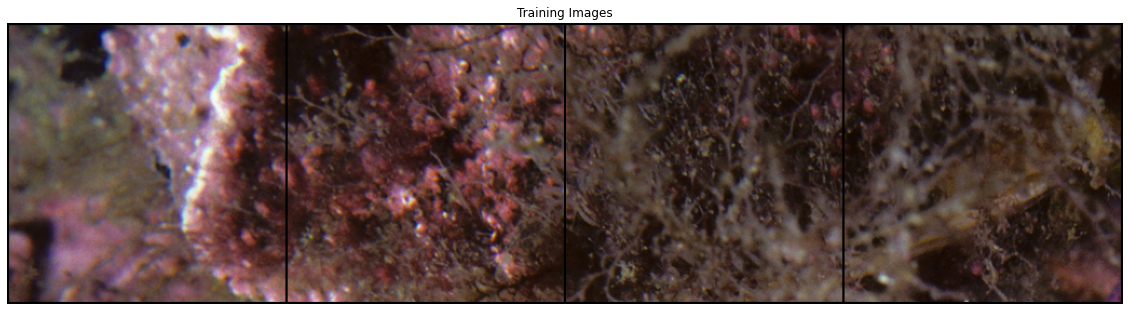

In [ ]:
HR_batch = next(iter(HR_train_dataloader))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(HR_batch[0].to(device)[:4], padding=2, normalize=True).cpu(),(1,2,0)))

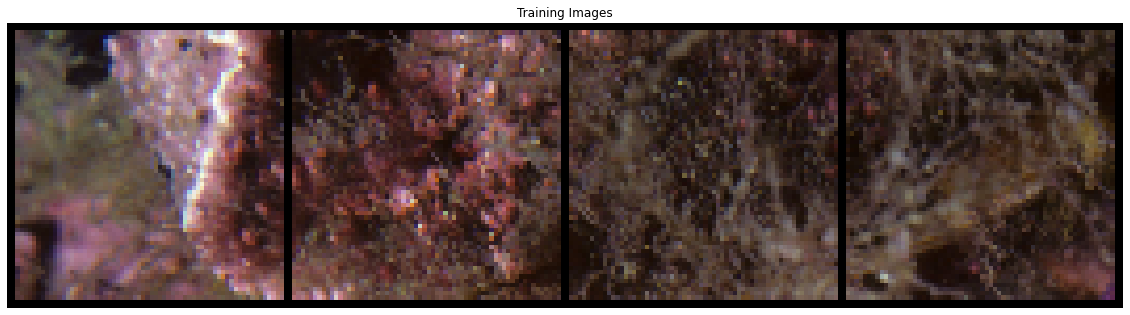

In [ ]:
LR_batch = next(iter(LR_train_dataloader))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(LR_batch[0].to(device)[:4], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
vgg = models.vgg19(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
class ResidualDenseBlock(n.Module):
    def __init__(self,in_channel = 64,inc_channel = 32, beta = 0.2):
        super().__init__()
        self.conv1 = n.Conv2d(in_channel, inc_channel, 3, 1, 1)
        self.conv2 = n.Conv2d(in_channel + inc_channel, inc_channel, 3, 1, 1)
        self.conv3 = n.Conv2d(in_channel + 2 * inc_channel, inc_channel, 3, 1, 1)
        self.conv4 = n.Conv2d(in_channel + 3 * inc_channel, inc_channel, 3, 1, 1)
        self.conv5 = n.Conv2d(in_channel + 4 * inc_channel,  in_channel, 3, 1, 1)
        self.lrelu = n.LeakyReLU()
        self.b = beta
        
    def forward(self, x):
        block1 = self.lrelu(self.conv1(x))
        block2 = self.lrelu(self.conv2(torch.cat((block1, x), dim = 1)))
        block3 = self.lrelu(self.conv3(torch.cat((block2, block1, x), dim = 1)))
        block4 = self.lrelu(self.conv4(torch.cat((block3, block2, block1, x), dim = 1)))
        out = self.conv5(torch.cat((block4, block3, block2, block1, x), dim = 1))
        
        return x + self.b * out

In [ ]:
class ResidualInResidualDenseBlock(n.Module):
    def __init__(self, in_channel = 64, out_channel = 32, beta = 0.2):
        super().__init__()
        self.RDB = ResidualDenseBlock(in_channel, out_channel)
        self.b = beta
    
    def forward(self, x):
        out = self.RDB(x)
        out = self.RDB(out)
        out = self.RDB(out)
        
        return x + self.b * out

In [ ]:
class Generator(n.Module):
    def __init__(self,in_channel = 3, out_channel = 3, noRRDBBlock = 23):
        super().__init__()   
        self.conv1 = n.Conv2d(3, 64, 3, 1, 1)

        RRDB = ResidualInResidualDenseBlock()
        RRDB_layer = []
        for i in range(noRRDBBlock):
            RRDB_layer.append(RRDB)
        self.RRDB_block =  n.Sequential(*RRDB_layer)

        self.RRDB_conv2 = n.Conv2d(64, 64, 3, 1, 1)
        self.upconv = n.Conv2d(64, 64, 3, 1, 1)

        self.out_conv = n.Conv2d(64, 3, 3, 1, 1)
    
    def forward(self, x):
        first_conv = self.conv1(x)
        RRDB_full_block = torch.add(self.RRDB_conv2(self.RRDB_block(first_conv)),first_conv)
        upconv_block1 = self.upconv(f.interpolate(RRDB_full_block, scale_factor = 2))
        upconv_block2 = self.upconv(f.interpolate(upconv_block1, scale_factor = 2))
        out = self.out_conv(upconv_block2)
        
        return out

In [ ]:
gen = Generator().to(device)
# summary(gen,(3,64,64))

In [ ]:
class Discriminator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,3,padding=1,bias=False)
        self.conv2 = n.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.bn2 = n.BatchNorm2d(64)
        self.conv3 = n.Conv2d(64,128,3,padding=1,bias=False)
        self.bn3 = n.BatchNorm2d(128)
        self.conv4 = n.Conv2d(128,128,3,stride=2,padding=1,bias=False)
        self.bn4 = n.BatchNorm2d(128)
        self.conv5 = n.Conv2d(128,256,3,padding=1,bias=False)
        self.bn5 = n.BatchNorm2d(256)
        self.conv6 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn6 = n.BatchNorm2d(256)
        self.conv7 = n.Conv2d(256,512,3,padding=1,bias=False)
        self.bn7 = n.BatchNorm2d(512)
        self.conv8 = n.Conv2d(512,512,3,stride=2,padding=1,bias=False)
        self.bn8 = n.BatchNorm2d(512)
        self.fc1 = n.Linear(512*16*16,1024)
        self.fc2 = n.Linear(1024,1)
        self.drop = n.Dropout2d(0.3)
        
    def forward(self,x):
        block1 = f.leaky_relu(self.conv1(x))
        block2 = f.leaky_relu(self.bn2(self.conv2(block1)))
        block3 = f.leaky_relu(self.bn3(self.conv3(block2)))
        block4 = f.leaky_relu(self.bn4(self.conv4(block3)))
        block5 = f.leaky_relu(self.bn5(self.conv5(block4)))
        block6 = f.leaky_relu(self.bn6(self.conv6(block5)))
        block7 = f.leaky_relu(self.bn7(self.conv7(block6)))
        block8 = f.leaky_relu(self.bn8(self.conv8(block7)))
        block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
        block9 = f.leaky_relu(self.fc1(block8))
#         block9 = block9.view(-1,block9.size(1)*block9.size(2)*block9.size(3))
        block10 = torch.sigmoid(self.drop(self.fc2(block9)))
        return block9

In [ ]:
disc = Discriminator().to(device)

In [ ]:
gen_optimizer = optim.Adam(gen.parameters(),lr=0.0002)
disc_optimizer = optim.Adam(disc.parameters(),lr=0.0002)

In [ ]:
class Losses():
    def __init__(self):
        super().__init__()
        self.disc_losss = n.BCEWithLogitsLoss()
        self.gen_losss = n.BCEWithLogitsLoss()
        self.vgg_loss = n.MSELoss()
        self.mse_loss = n.MSELoss()
        self.lamda = 0.005
        self.eeta = 0.02 
        
    def calculateLoss(self,discriminator, generator,LR_image, HR_image):

        disc_optimizer.zero_grad()
        generated_output = generator(LR_image.to(device).float())
        fake_data = generated_output.clone()
        fake_label = discriminator(fake_data)

        
        HR_image_tensor = HR_image.to(device).float()
        real_data = HR_image_tensor.clone()
        real_label = discriminator(real_data)
        
        relativistic_d1_loss = self.disc_losss((real_label - torch.mean(fake_label)), torch.ones_like(real_label, dtype = torch.float))
        relativistic_d2_loss = self.disc_losss((fake_label - torch.mean(real_label)), torch.zeros_like(fake_label, dtype = torch.float))      

        d_loss = (relativistic_d1_loss + relativistic_d2_loss) / 2
        d_loss.backward(retain_graph = True)
        disc_optimizer.step()

        fake_label_ = discriminator(generated_output)
        real_label_ = discriminator(real_data)
        gen_optimizer.zero_grad()

        g_real_loss = self.gen_losss((fake_label_ - torch.mean(real_label_)), torch.ones_like(fake_label_, dtype = torch.float))
        g_fake_loss = self.gen_losss((real_label_ - torch.mean(fake_label_)), torch.zeros_like(fake_label_, dtype = torch.float))
        g_loss = (g_real_loss + g_fake_loss) / 2
        
        v_loss = self.vgg_loss(vgg.features[:6](generated_output),vgg.features[:6](real_data))
        m_loss = self.mse_loss(generated_output,real_data)
        generator_loss = self.lamda * g_loss + v_loss + self.eeta * m_loss
        generator_loss.backward()
        gen_optimizer.step()

        return d_loss,generator_loss

In [ ]:
def loadImages(imageList,path):
    images=[]
    for image in (imageList):
        img = cv2.imread(os.path.join(path,image))
        img = np.moveaxis(img, 2, 0)
#         print(img.shape)
        images.append(img)
    return np.array(images)

In [ ]:
epochs = 100

In [ ]:
weight_file = "drive/MyDrive/ColabNotebooks/ESRGAN-pytorch/ESRGAN_weights"
out_path = "drive/MyDrive/ColabNotebooks/ESRGAN-pytorch/out"

if not os.path.exists(weight_file):
    os.makedirs(weight_file)

if not os.path.exists(out_path):
    os.makedirs(out_path)

test_image_path = os.path.join(os.getcwd(),"drive/MyDrive/datasets/Set5/LRbicx4")

In [ ]:
images = os.listdir(test_image_path)

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [ ]:
def imagePostProcess(imagedir,modelPath):
    imagelist=[]
#     images = os.listdir(imagedir)
    for img in imagedir:
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(test_image_path,img)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
        imagelist.append(img)
    imagearray = np.array(imagelist)/255
    
    imagearrayPT = np.moveaxis(imagearray,3,1)

    model = load_checkpoint(modelPath)
    im_tensor = torch.from_numpy(imagearrayPT).float()
    out_tensor = model(im_tensor)
    out = out_tensor.numpy()
    out = np.moveaxis(out,1,3)
    out = np.clip(out,0,1)
    
    return out

In [ ]:
for epoch in (range(epochs)):
    warnings.filterwarnings('ignore')
    dloss_list=[]
    gloss_list=[]
    
    for data_idx ,(HR_data, LR_data) in tqdm_notebook(enumerate(zip(HR_train_dataloader,LR_train_dataloader)), total = len(LR_train_dataloader)):
        HR_data, LR_data = HR_data[0], LR_data[0]
        
        
        disc_loss, gen_loss = Losses().calculateLoss(disc, gen, LR_data, HR_data)
        dloss_list.append(disc_loss.item())
        gloss_list.append(gen_loss.item())
        # print(disc_loss, gen_loss)
        torch.cuda.empty_cache()
#         if(data_idx == 125):
#             break

    print("Epoch ::::  "+str(epoch+1)+"  d_loss ::: "+str(np.mean(dloss_list))+"  g_loss :::"+str(np.mean(gloss_list)))

    if(epoch%3==0):
        
        checkpoint = {'model': Generator(),
              'input_size': 64,
              'output_size': 256,
              'state_dict': gen.state_dict()}
        torch.save(checkpoint,os.path.join(weight_file,"ESRGAN"+str(epoch+1)+".pth"))

  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  1  d_loss ::: 0.15388939007669625  g_loss :::5.315753485671879


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  2  d_loss ::: 0.1157507930951025  g_loss :::2.6202941302256817


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  3  d_loss ::: 0.0767560112463719  g_loss :::2.5467388702465166


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  4  d_loss ::: 0.08481658622034469  g_loss :::2.5546278759259455


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  5  d_loss ::: 0.15535578798691327  g_loss :::2.500722890076235


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  6  d_loss ::: 0.1748852086093474  g_loss :::2.4367497475836917


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  7  d_loss ::: 0.16572519972899408  g_loss :::2.3620558554771756


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  8  d_loss ::: 0.12433793263625467  g_loss :::2.3581605910949044


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  9  d_loss ::: 0.1101118711864924  g_loss :::2.346782376974855


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  10  d_loss ::: 0.19359630277019976  g_loss :::2.2834938881343216


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  11  d_loss ::: 0.1587263235406863  g_loss :::2.3735818443235814


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  12  d_loss ::: 0.09975081189795908  g_loss :::2.3050011178497716


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  13  d_loss ::: 0.01841827385622853  g_loss :::2.299620107978056


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f868b4ebc20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    

  0%|          | 0/877 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f868b4ebc20>self._shutdown_workers()
Exception ignored in: 
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f868b4ebc20>    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f868b4ebc20>    
self._shutdown_workers()
if w.is_alive():Traceback (most recent call last):


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packag

Epoch ::::  14  d_loss ::: 0.18096828785683583  g_loss :::2.2669638603110136


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  15  d_loss ::: 0.03413348336808442  g_loss :::2.292992158161058


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  16  d_loss ::: 0.1253398810571734  g_loss :::2.2418422557778888


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  17  d_loss ::: 0.007216237574518195  g_loss :::2.235709151395404


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  18  d_loss ::: 0.06089419848660066  g_loss :::2.2664095484009152


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  19  d_loss ::: 0.027790640243149776  g_loss :::2.257152346403528


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  20  d_loss ::: 0.02446151269438723  g_loss :::2.194248261123454


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  21  d_loss ::: 0.005351259717181029  g_loss :::2.2102967776196714


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  22  d_loss ::: 0.05175464857451676  g_loss :::2.1941243427271444


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  23  d_loss ::: 0.0018588927182796356  g_loss :::2.144628576543543


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  24  d_loss ::: 0.002755540144581039  g_loss :::2.136342659439709


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  25  d_loss ::: 0.0015464692389097544  g_loss :::2.1704199683588072


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  26  d_loss ::: 1.5661484154527414e-05  g_loss :::2.1807622381038922


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  27  d_loss ::: 0.00462105605527061  g_loss :::2.2132111456703942


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  28  d_loss ::: 0.22680267255597736  g_loss :::2.174383919321833


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  29  d_loss ::: 0.054857179913982645  g_loss :::2.2233541602748814


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  30  d_loss ::: 0.06493233755279841  g_loss :::2.405363975322148


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  31  d_loss ::: 0.13633371440184436  g_loss :::2.2560706172922167


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  32  d_loss ::: 0.09304879002709368  g_loss :::2.1314734491597154


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  33  d_loss ::: 0.009584473315062658  g_loss :::2.049709214386079


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  34  d_loss ::: 0.0033711976957283892  g_loss :::2.063824883973313


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  35  d_loss ::: 4.616097307316879e-05  g_loss :::2.08598944334103


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  36  d_loss ::: 2.4027778616497478e-05  g_loss :::2.08668332876576


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  37  d_loss ::: 1.2329581688728735e-05  g_loss :::2.0912619258193224


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  38  d_loss ::: 0.00011061130363110878  g_loss :::2.083626612383732


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  39  d_loss ::: 0.017275606997338815  g_loss :::2.0782250744484987


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  40  d_loss ::: 0.06743355418718432  g_loss :::2.096662872427376


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  41  d_loss ::: 0.06279166429160654  g_loss :::2.055462804953212


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  42  d_loss ::: 0.001411782120216771  g_loss :::2.0630635873519707


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  43  d_loss ::: 2.907148752214619e-05  g_loss :::2.0772542140298995


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  44  d_loss ::: 2.2430594886706377e-05  g_loss :::2.068812301826314


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  45  d_loss ::: 2.3097764911710734e-06  g_loss :::2.060788945705888


  0%|          | 0/877 [00:00<?, ?it/s]

Epoch ::::  46  d_loss ::: 6.732957402863248e-05  g_loss :::2.0533929660729426


  0%|          | 0/877 [00:00<?, ?it/s]

In [ ]:
from torchmetrics import PeakSignalNoiseRatio as psnr
from torchmetrics import StructuralSimilarityIndexMeasure as ssim

In [ ]:
def show_samples(sample_images):
    figure, axes = plt.subplots(1, sample_images.shape[0], figsize = (10,10))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray((image_array * 255).astype('uint8'))
    plt.savefig(os.path.join(os.getcwd(),"drive/MyDrive/ColabNotebooks/ESRGAN-pytorch/out/SR")+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [ ]:
#to do: calculate psnr , ssim
epoch = 100
out_images = imagePostProcess(images[-5:],os.path.join(weight_file,"ESRGAN"+str(epoch+1)+".pth"))
show_samples(out_images)